# CNN For Fashion MNIST Dataset

Contains the code for CNN base model. 

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

#### Getting datasets

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

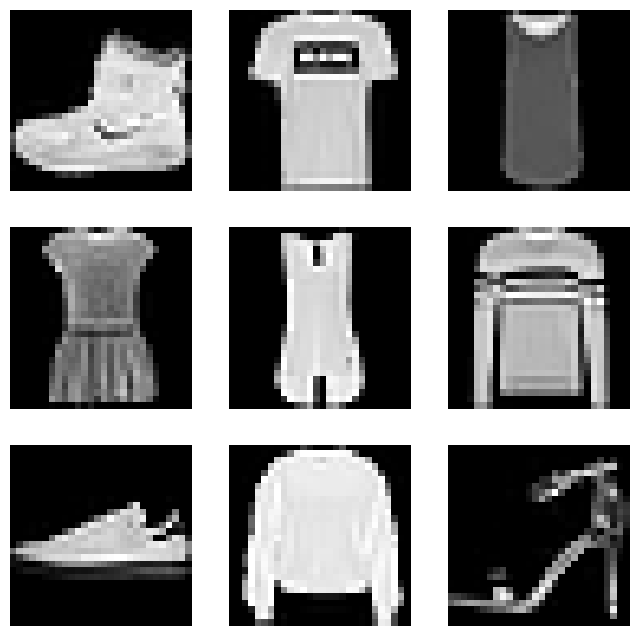

In [6]:
# plot the first few images
import matplotlib.pyplot as plt

def print_first_n_images(train_dataset, n):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(n):
        image, label = train_dataset[i]
        ax = axes[i // 3, i % 3]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

print_first_n_images(train_dataset, 9)

#### CNN

In [4]:
# optimal hyperparameters:
batch_size = 64
fc_layer_size = 512
activation_fn = nn.PReLU()

from test_harness import load_dataset, prep_pixels, define_model
from tqdm import tqdm
from torch import optim

train_loader, test_loader = load_dataset(train_dataset, test_dataset, batch_size)
train_loader, test_loader = prep_pixels(train_loader, test_loader)

model = define_model(fc_layer_size, activation_fn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

accuracies = []

best_accuracy = 0.0
patience_counter = 0

for epoch in range(20):
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    for i, (images, labels) in pbar:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0:
            pbar.set_description(f'Epoch [{epoch + 1}/{20}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item()}')

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pbar_test = tqdm(test_loader)
        for images, labels in pbar_test:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar_test.set_description(f'Accuracy: {100 * correct / total:.2f}%')

        accuracy = 100 * correct / total

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0

        else:
            patience_counter += 1
            if patience_counter >= 3:
                print(f'Early stopping at epoch {epoch + 1}')
                break

print(f'Final accuracy: {best_accuracy:.2f}%')


Epoch [1/20], Step [800/938], Loss: 0.259164422750473: 100%|██████████| 938/938 [00:16<00:00, 56.72it/s]  
Accuracy: 86.40%: 100%|██████████| 157/157 [00:01<00:00, 119.79it/s]
Epoch [2/20], Step [800/938], Loss: 0.18663428723812103: 100%|██████████| 938/938 [00:17<00:00, 54.77it/s]
Accuracy: 88.66%: 100%|██████████| 157/157 [00:01<00:00, 120.13it/s]
Epoch [3/20], Step [800/938], Loss: 0.28159597516059875: 100%|██████████| 938/938 [00:16<00:00, 58.42it/s]
Accuracy: 89.44%: 100%|██████████| 157/157 [00:01<00:00, 117.68it/s]
Epoch [4/20], Step [800/938], Loss: 0.1334751397371292: 100%|██████████| 938/938 [00:16<00:00, 58.40it/s] 
Accuracy: 89.92%: 100%|██████████| 157/157 [00:01<00:00, 117.99it/s]
Epoch [5/20], Step [800/938], Loss: 0.11810232698917389: 100%|██████████| 938/938 [00:16<00:00, 57.91it/s]
Accuracy: 89.92%: 100%|██████████| 157/157 [00:01<00:00, 120.10it/s]
Epoch [6/20], Step [800/938], Loss: 0.27412527799606323: 100%|██████████| 938/938 [00:16<00:00, 55.82it/s]
Accuracy: 91.

Early stopping at epoch 12
Final accuracy: 91.53%


In [5]:
torch.save(model.state_dict(), 'cnn.pt')

#### Final Accuracy for CNN: 91.53%